#**Smart Factory Energy Prediction**

###**Imports**

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

###**Load Data, Cleaning, Visualizing, Feature Engineering**

In [92]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the dataset.
    """
    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Feature Engineering
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = df['day_of_week'] >= 5
    df['lag1_energy'] = df['equipment_energy_consumption'].shift(1)
    df['lag2_energy'] = df['equipment_energy_consumption'].shift(2)
    df['equipment_energy_consumption'] = pd.to_numeric(df['equipment_energy_consumption'], errors='coerce')
    df['equipment_energy_consumption_roll_mean_3'] = df['equipment_energy_consumption'].rolling(window=3).mean()

    # Data Cleaning
    df.replace('unknown', np.nan, inplace=True)
    df.drop(columns=['random_variable1', 'random_variable2'], inplace=True)
    df.dropna(inplace=True)

    # Visualize time series energy trend
    plt.figure(figsize=(14, 4))
    plt.plot(df['timestamp'], df['equipment_energy_consumption'], label='Energy Consumption')
    plt.title('Equipment Energy Consumption Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Energy Consumption')
    plt.tight_layout()
    plt.show()

    # Encode categorical variables
    for col in df.select_dtypes(include='object').columns:
        df[col] = pd.factorize(df[col])[0]

    # Correlation heatmap
    plt.figure(figsize=(20, 15))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    df.drop(columns=['timestamp'], inplace=True)

    return df

###**Split Data**

In [93]:
def split_and_scale_data(df):
    """
    Split the data into training and testing sets and scale the features.
    """
    X = df.drop(columns='equipment_energy_consumption')
    y = df['equipment_energy_consumption']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test, X.columns

###**Hyperparameter Tuning**

In [94]:
def perform_grid_search(X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV for RandomForestRegressor.
    """
    rf = RandomForestRegressor(random_state=42)
    rf_params = {
        'n_estimators': [100, 150],
        'max_depth': [8, 10, 12]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    rf_grid = GridSearchCV(rf, rf_params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    return rf_grid.best_estimator_

###**Stacking Regressor - Model Development**

In [95]:
def train_stacking_regressor(X_train, y_train, best_rf):
    """
    Train a stacking regressor using the best RandomForestRegressor, XGBRegressor, and GradientBoostingRegressor.
    """
    xgb = XGBRegressor(random_state=42, verbosity=0)
    gb = GradientBoostingRegressor(random_state=42)
    meta = Ridge()

    stack = StackingRegressor(
        estimators=[('rf', best_rf), ('xgb', xgb), ('gb', gb)],
        final_estimator=meta,
        passthrough=True
    )
    stack.fit(X_train, y_train)
    return stack

###**Model Evaluation**

In [96]:
def evaluate_model(y_true, y_pred):
    """
    Evaluate the model performance using RMSE, MAE, and R² metrics.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.3f}")
    return rmse, mae, r2


###**Feature Importance**

In [97]:
def plot_feature_importance(model, feature_names):
    """
    Plot feature importances from the RandomForestRegressor.
    """
    importances = model.feature_importances_
    feat_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    feat_importance.plot(kind='bar')
    plt.title("Random Forest Feature Importances")
    plt.tight_layout()
    plt.show()

###**Prediction Plotiing**

In [98]:
def plot_predictions(y_true, y_pred):
    """
    Plot actual vs predicted values and residuals.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(y_true.values, label='Actual')
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title('Actual vs. Predicted Equipment Energy Consumption')
    plt.legend()
    plt.tight_layout()
    plt.show()

    residuals = y_true.values - y_pred
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Error')
    plt.tight_layout()
    plt.show()


###**Main Function**

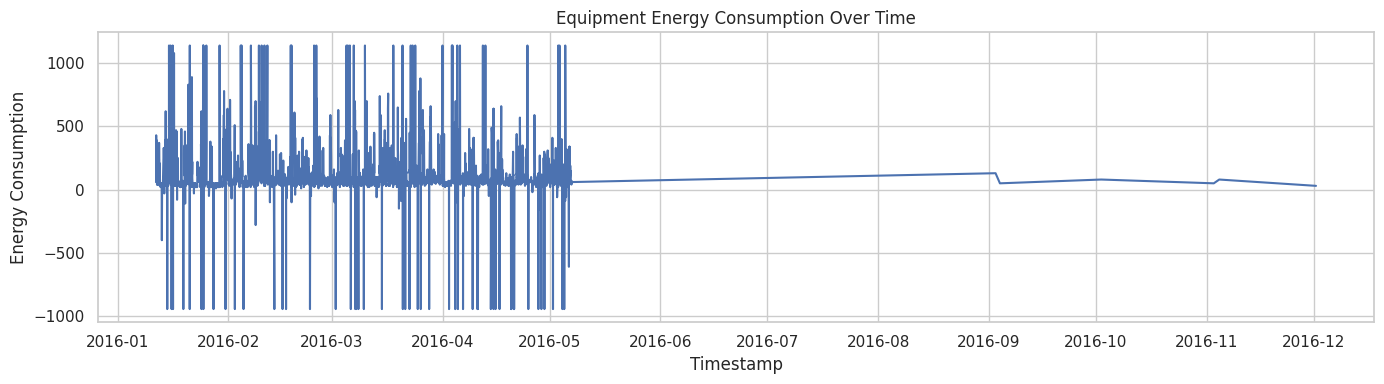

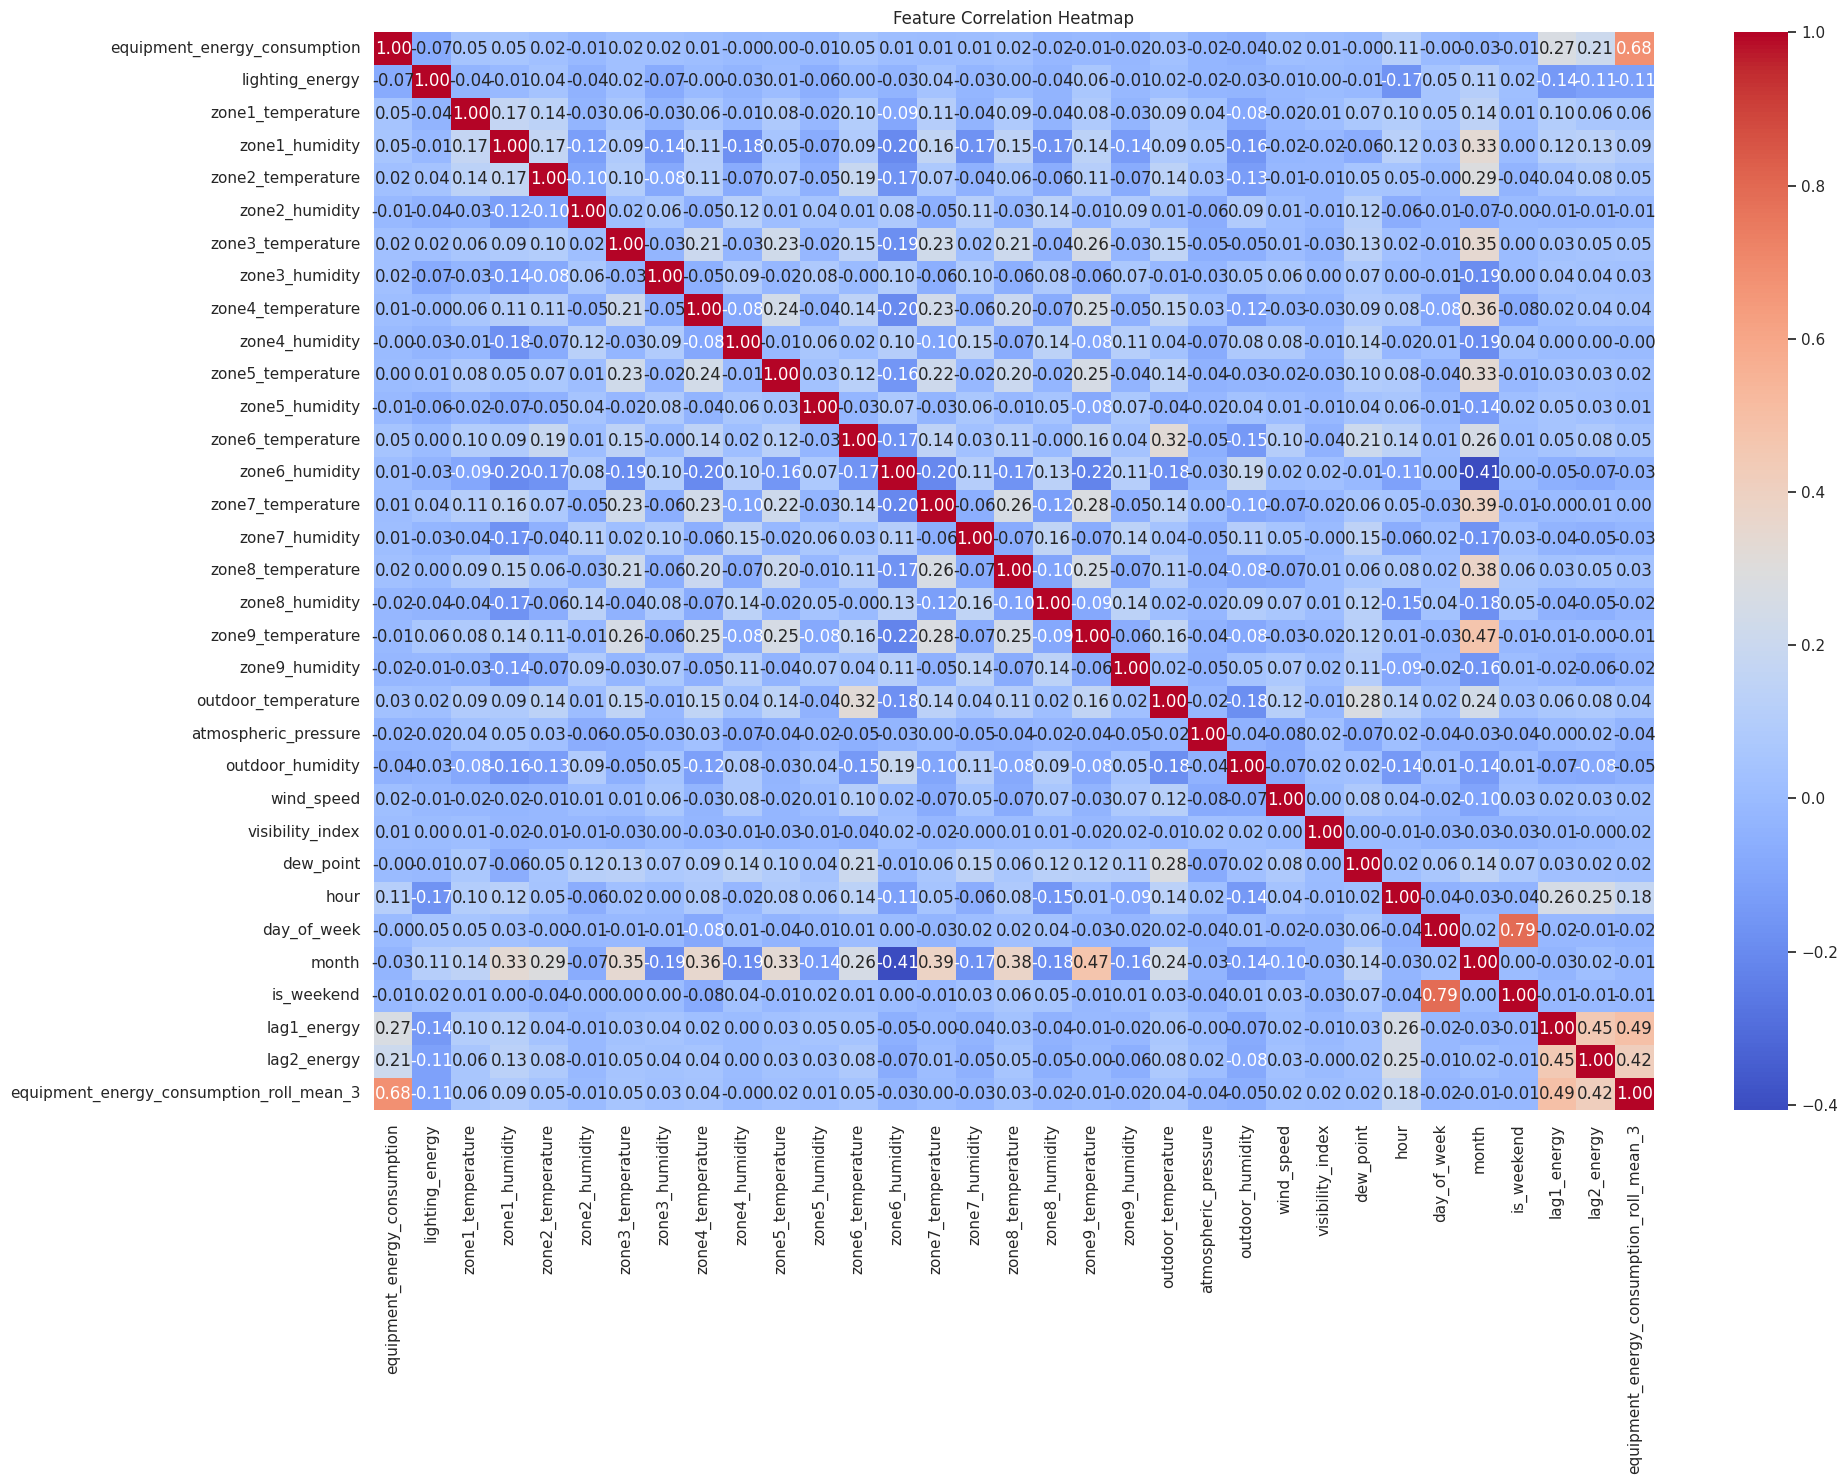


Model Performance on Test Set:
RMSE: 86.39
MAE: 28.49
R² Score: 0.768


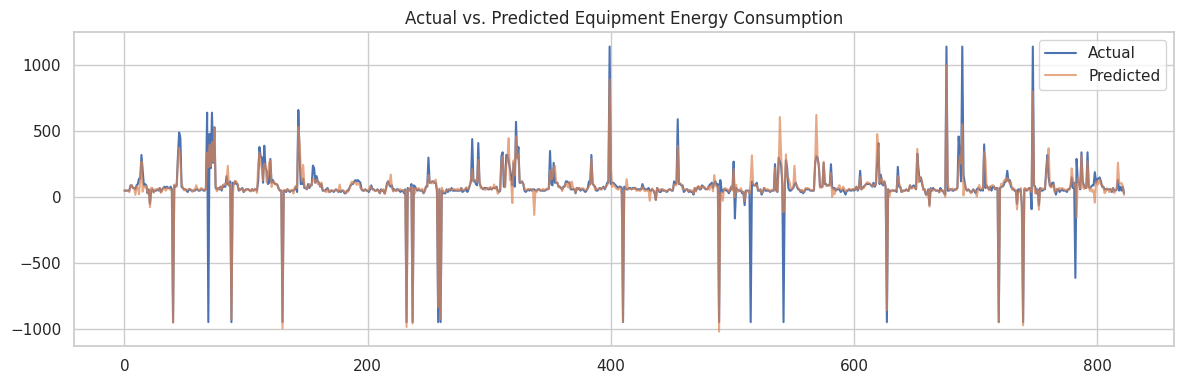

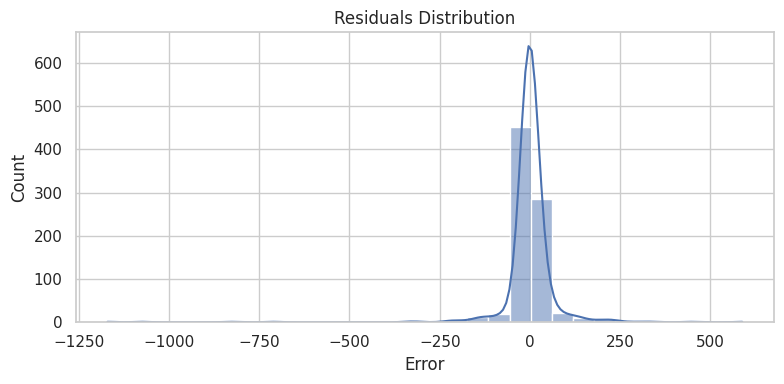

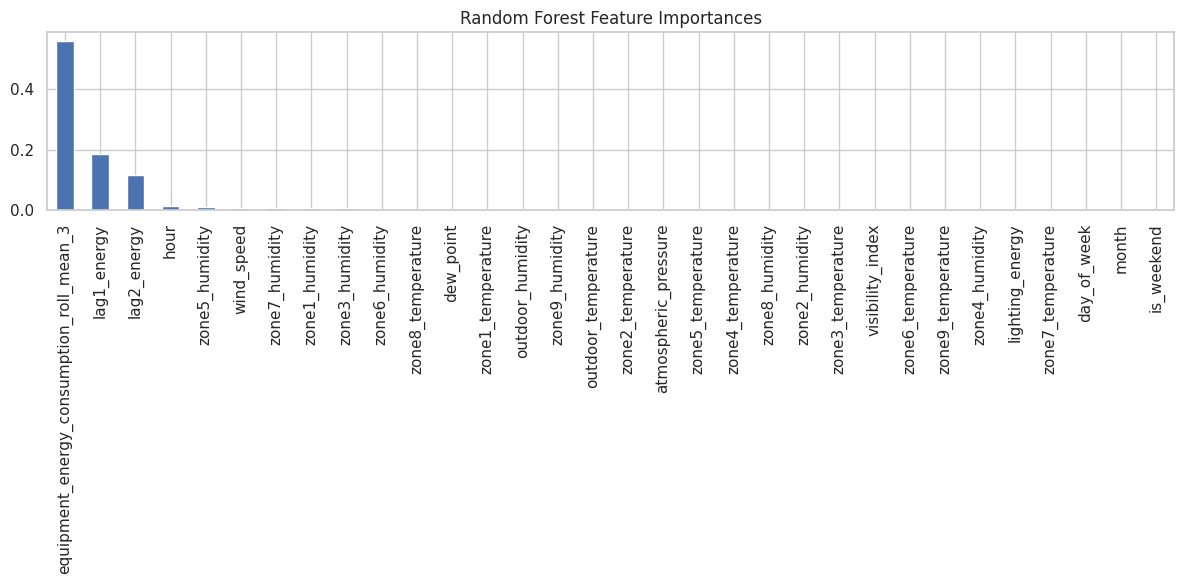

In [99]:
def main():
    # Load and preprocess data
    df = load_and_preprocess_data("data.csv")

    # Split and scale data
    X_train, X_test, y_train, y_test, feature_names = split_and_scale_data(df)

    # Perform hyperparameter tuning
    best_rf = perform_grid_search(X_train, y_train)

    # Train stacking regressor
    stack = train_stacking_regressor(X_train, y_train, best_rf)

    # Predict and evaluate
    y_pred = stack.predict(X_test)
    print("\nModel Performance on Test Set:")
    evaluate_model(y_test, y_pred)

    # Plot results
    plot_predictions(y_test, y_pred)
    plot_feature_importance(best_rf, feature_names)

if __name__ == "__main__":
    main()

###**Key Findings & Insights**

#### Model Performance
- Final stacked model achieved **RMSE of 86.39** and **R² of 0.768**.
- Model explains **~77% of the variance** in energy consumption.

#### Top Features
- **Lag features** and **rolling averages** were most important.
- **Hour, day of week, and month** captured strong time patterns.
- **Weekends** had a distinct impact on energy usage.

#### Feature Engineering
- **Lag and rolling stats** improved prediction.
- **Time-based features** added valuable seasonality information.

#### Modeling Approach
- **Stacking (RF + XGB + GB)** outperformed individual models.
- **GridSearch** improved **Random Forest** performance.

#### Preprocessing
- **Missing values** and **outliers** handled carefully.
- Features were **scaled** and **categorical data** encoded properly.
